In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

In [3]:
solubility = pd.read_csv('../data/delaney.csv')

In [4]:
# Split into train, dev, and test sets
train = solubility.sample(frac=.8, random_state=1)
valid = solubility[~solubility.index.isin(train.index)].sample(frac=.5, random_state=1)
test = solubility[~solubility.index.isin(train.index) & ~solubility.index.isin(valid.index)]

In [5]:
# Transform inputs into graph encodings
from nfp.preprocessing import SmilesPreprocessor

preprocessor = SmilesPreprocessor()
train_inputs = preprocessor.fit(train.smiles)
valid_inputs = preprocessor.predict(valid.smiles)

100%|██████████| 113/113 [00:00<00:00, 1465.68it/s]


In [68]:
# define keras model
import tensorflow as tf
from tensorflow.keras import layers

class MessageBlock(layers.Layer):
    
    def __init__(self, atom_dimension):
        super(MessageBlock, self).__init__()
        self.atom_bn = layers.BatchNormalization()
        self.bond_bn = layers.BatchNormalization()
        self.bond_update_1 = layers.Dense(2*atom_dimension, activation='relu')
        self.bond_update_2 = layers.Dense(atom_dimension)        
        self.atom_update = layers.Dense(atom_dimension)
        
    def call(self, original_atom_state, original_bond_state, connectivity):
        
        # Batch norm on incoming layers
        atom_state = self.atom_bn(original_atom_state)
        bond_state = self.bond_bn(original_bond_state)
        
        # Gather atoms to bond dimension
        target_atom = tf.gather(atom_state, connectivity[:, 0])        
        source_atom = tf.gather(atom_state, connectivity[:, 1])

        # Update bond states with source and target atom info
        new_bond_state = tf.concat([source_atom, target_atom, bond_state], 1)
        new_bond_state = self.bond_update_1(new_bond_state)
        new_bond_state = self.bond_update_2(new_bond_state)       
        
        # Update atom states with neighboring bonds
        source_atom = self.atom_update(source_atom)
        messages = source_atom * new_bond_state
        messages = tf.math.segment_sum(messages, connectivity[:, 0])
        
        # Add new states to their incoming values (residual connection)
        bond_state = original_bond_state + new_bond_state
        atom_state = original_atom_state + messages
        
        return atom_state, bond_state
    

class GraphNetwork(tf.keras.Model):
    
    def __init__(self, preprocessor, atom_dimension, num_messages):
        super(GraphNetwork, self).__init__()
        self.atom_embedding = layers.Embedding(
            preprocessor.atom_classes, atom_dimension, name='atom_embedding')
        self.atom_mean = layers.Embedding(
            preprocessor.atom_classes, 1, name='atom_mean')        
        self.bond_embedding = layers.Embedding(
            preprocessor.bond_classes, atom_dimension, name='bond_embedding')
        self.message_layers = [MessageBlock(atom_dimension) for _ in range(num_messages)]
        self.output_atomwise_dense = layers.Dense(1)
        self.dropout_layer = layers.Dropout(.5)

    @tf.function(input_signature=[
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
        tf.TensorSpec(shape=(None,), dtype=tf.int64),
        tf.TensorSpec(shape=(None, 2), dtype=tf.int64),
    ])
    def call(self, atom_types, bond_types, node_graph_indices, connectivity):
        
        # Initialize the atom and bond embedding vectors
        atom_state = self.atom_embedding(atom_types)
        bond_state = self.bond_embedding(bond_types)
        
        # Perform the message passing
        for message_layer in self.message_layers:
            atom_state, bond_state = message_layer(atom_state, bond_state, connectivity)
                    
        atom_state = self.dropout_layer(atom_state)
        
        # Reduce atom to a single prediction
        atom_solubility = self.output_atomwise_dense(atom_state) + self.atom_mean(atom_types)
        
        # Sum over all atoms in a mol
        mol_solubility = tf.math.segment_mean(atom_solubility, node_graph_indices)
            
        return tf.squeeze(mol_solubility)

In [69]:
from tqdm import tqdm
import warnings

In [70]:
from nfp.preprocessing import GraphSequence

train_sequence = GraphSequence(
    train_inputs, tf.convert_to_tensor(train['measured log solubility in mols per litre'], dtype=tf.float32),
    shuffle=True, batch_size=5, final_batch=False)

valid_sequence = GraphSequence(
    valid_inputs, tf.convert_to_tensor(valid['measured log solubility in mols per litre'], dtype=tf.float32),
    shuffle=False, batch_size=20, final_batch=True)

model = GraphNetwork(preprocessor, atom_dimension=64, num_messages=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.MeanAbsoluteError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')


# @tf.function(input_signature=train_step_signature)
def train_step(atom, bond, node_indices, connectivity, targets):
    with tf.GradientTape() as tape:
        predictions = model(atom, bond, node_indices, connectivity, training=True)
        loss = loss_fn(predictions, targets)
        
    gradients = tape.gradient(loss, model.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))        
    train_loss(loss)
    
    
# @tf.function(input_signature=train_step_signature)
def valid_step(atom, bond, node_indices, connectivity, targets):
    predictions = model(atom, bond, node_indices, connectivity, training=False)
    loss = loss_fn(predictions, targets)
    valid_loss(loss)

    
for epoch in range(25):
    print(f'Epoch: {epoch}', end='\t')
    for i, (inputs, y) in enumerate(train_sequence):
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            train_step(inputs['atom'], inputs['bond'],
                       inputs['node_graph_indices'], inputs['connectivity'], y)

    print(f'Train Loss: {train_loss.result():.3f}', end='\t')
            
    for inputs, y in valid_sequence:
        valid_step(inputs['atom'], inputs['bond'],
                   inputs['node_graph_indices'], inputs['connectivity'], y)        
        
    print(f'Valid Loss: {valid_loss.result():.3f}')    
            
    train_sequence.on_epoch_end()
    valid_sequence.on_epoch_end()

Epoch: 0	Train Loss: 2.353	Valid Loss: 1.632
Epoch: 1	Train Loss: 1.972	Valid Loss: 1.555
Epoch: 2	Train Loss: 1.787	Valid Loss: 1.410
Epoch: 3	Train Loss: 1.638	Valid Loss: 1.381
Epoch: 4	Train Loss: 1.537	Valid Loss: 1.295
Epoch: 5	Train Loss: 1.467	Valid Loss: 1.224
Epoch: 6	Train Loss: 1.405	Valid Loss: 1.211
Epoch: 7	Train Loss: 1.353	Valid Loss: 1.175
Epoch: 8	Train Loss: 1.308	Valid Loss: 1.132
Epoch: 9	Train Loss: 1.269	Valid Loss: 1.097
Epoch: 10	Train Loss: 1.232	Valid Loss: 1.075
Epoch: 11	Train Loss: 1.203	Valid Loss: 1.056
Epoch: 12	Train Loss: 1.179	Valid Loss: 1.043
Epoch: 13	Train Loss: 1.159	Valid Loss: 1.026
Epoch: 14	Train Loss: 1.140	Valid Loss: 1.005
Epoch: 15	Train Loss: 1.121	Valid Loss: 0.994
Epoch: 16	Train Loss: 1.104	Valid Loss: 0.982
Epoch: 17	Train Loss: 1.086	Valid Loss: 0.969
Epoch: 18	Train Loss: 1.071	Valid Loss: 0.953
Epoch: 19	Train Loss: 1.059	Valid Loss: 0.944
Epoch: 20	Train Loss: 1.049	Valid Loss: 0.936
Epoch: 21	Train Loss: 1.037	Valid Loss: 0.92

In [71]:
test_inputs = preprocessor.predict(test.smiles)
test_sequence = GraphSequence(test_inputs, shuffle=False, final_batch=True, batch_size=1000)
stacked_test_inputs = test_sequence[0]

100%|██████████| 113/113 [00:00<00:00, 1457.99it/s]


In [72]:
test_predictions = model(stacked_test_inputs['atom'], stacked_test_inputs['bond'], 
                         stacked_test_inputs['node_graph_indices'],
                         stacked_test_inputs['connectivity'], training=False)

Text(0.5, 1.0, 'Test MAE: 0.982')

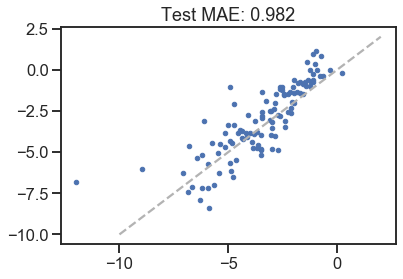

In [73]:
plt.plot(test_predictions.numpy(), test['measured log solubility in mols per litre'], '.')
plt.plot([-10, 2], [-10, 2], '--', color='.7')
mae = (test_predictions.numpy() - test['measured log solubility in mols per litre']).abs().mean()
plt.title(f'Test MAE: {mae:.3f}')

In [74]:
tf.saved_model.save(model, 'test.tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: test.tf/assets
